In [1]:
import numpy as np
import pdb

from functools import reduce
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd
from scipy.optimize import minimize
from scipy.stats import norm, multivariate_normal
from sklearn.neighbors import KernelDensity as kd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

In [2]:
# For reproducibility
rng = rnd.RandomState(1083463236)

In [3]:
# mixing proportions: 0.5 and 0.5
# mean0 = mean1 = 0
# sigma1 = 1
# sigma0: parameter of interest
sigma1 = 1
sigma0 = 4
# number of data points
n = 100000
# nu is the ratio of noise to data samples in NCE
nu = 1
#observed data
z = rnd.uniform(0,1, n) > 0.5 
x = ((z==0)*(rnd.randn(n)*sigma0) + (z==1)*(rnd.randn(n)*sigma1)) 
#noise
y = sigma0 * rnd.randn(n*nu)

In [4]:
# correctly normalised model
def pm(u, theta):
    return 0.5*(norm.pdf(u,0,theta) + norm.pdf(u, 0, sigma1))
# noise that matches the larger std
def pn(u):
    return norm.pdf(u,0, sigma0) 
# quick hack: generally better to work in log domain!
def h(u, theta):
    return np.log(pm(u, theta)/pn(u))

In [5]:
# J is the true NCE objective function
thetas = np.arange(0.01, 8, 0.1)
n_theta = len(thetas)
J = np.zeros(n_theta)
for k in range(n_theta):
    theta_k = thetas[k]
    a0 = 1 + nu*np.exp(-h(x,theta_k))
    a1 = 1 + (1/nu)*np.exp(h(y,theta_k))
    J[k] = -np.mean(np.log(a0)) - nu*np.mean(np.log(a1))

# Using variational EM-type procedure to maximize J1

## math

Now we try using a variational q distribution of the form:

$$ q(z=0 \ | \ u; \textbf{w}) = \sigma(\textbf{w}^T \tilde{\textbf{u}}) = \sigma(w_0 + w_1u + w_2u^2) $$

where $\sigma$ is the sigmoid function,  $\textbf{w}$ are the variational parameters and $\tilde{\textbf{u}} := (1, u, u^2)^T$. Note that we can recover q as defined in the previous section by setting:
$$ \textbf{w} = \left[-\log(\theta), \ 0, \ \frac{1}{2}(1 - \theta^{-2}) \right] $$
We will then alternate optimisation of $\theta$ and $\textbf{w}$ (i.e apply a form of coordinate ascent).

To optimise our objective function w.r.t to $\textbf{w}$, we need to find the gradient of:

\begin{align}
J_1^k(\textbf{w}) = \color{red}{ - \mathbb{E}_{x} \mathbb{E}_{z \sim q(z \ | \ u; \textbf{w})} \left[ \log(1 + \frac{\nu}{r(x, z; \textbf{w})}) \right]} - \color{blue}{ \nu \mathbb{E}_{y}  \left[ \log(1 + \frac{1}{\nu} \mathbb{E}_{z \sim q(z \ | \ u; \textbf{w})}[r(y, z; \textbf{w})] ) \right]}
\end{align}

where 

$$ r(u,z, \textbf{w}) = \frac{\phi(u, z; \theta_k)}{q_k(z \ | \ u; \textbf{w}) p_y(u)}$$

Note that this is a *stochastic* optimisation problem, since we are differentiating w.r.t to parameters of q, but there is an expectation over q. This complicates the situation.

Since q is a bernouilli distribution, we can analytically write down what the expectation is (as we do below) and then differentiate. For more complex distributions, we will need to use something else: perhaps a pathwise derivative estimator (http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/) or score function estimator (http://blog.shakirm.com/2015/11/machine-learning-trick-of-the-day-5-log-derivative-trick/).

To calculate $\nabla_{\textbf{w}} J_1^k(\textbf{w})$, we first analytically evaluate the expectations. Doing this, we see that the blue term will no longer depend on q (since q was only introduced in the blue term for importance sampling, which we now undo). Hence, we only have to evaluate:

\begin{align}
\nabla_{\textbf{w}} J_1^k(\textbf{w}) & = \color{red}{\nabla_{\textbf{w}} \left[ -\mathbb{E}_x \sum_{i=1}^2 q(i \ | \ x; \textbf{w}) \log \left( 1 + \nu\frac{ q(i \ | \ x; \textbf{w}) p_y(x)}{\phi(x, i, \theta_k)} \right) \right]}
\end{align}

The gradient of a term inside the summation has the form:

\begin{align}
\nabla_{\textbf{w}} \left[ q_i(\textbf{w}) \log( 1 + a_iq_i(\textbf{w})) \right] = \left( \log( 1 + a_iq_i(\textbf{w})) + \frac{a_i}{1 + a_i q_i(\textbf{w})} \right) \nabla_{\textbf{w}} q_i(\textbf{w})
\end{align}

Where we have simplified notation by setting: $q_i(\textbf{w}) = q(i \ | \ x; \textbf{w})$ and $ a_i = \frac{p_y(x)}{\phi(x, i, \theta_k)}$.

Observe that 

$$\nabla_{\textbf{w}} q_1(\textbf{w}) =  \nabla_{\textbf{w}} \left[ 1 - q_0(\textbf{w}) \right] = - \nabla_{\textbf{w}} q_0(\textbf{w}) $$

and so our original gradient becomes:

\begin{align}
\nabla_{\textbf{w}} J_1^k(\textbf{w}) & = \color{red}{ -\mathbb{E}_x  \left( \log \left( \frac{ 1 + a_0q_0(\textbf{w})}{1 + a_1q_1(\textbf{w})} \right) + \frac{a_0}{1 + a_0 q_0(\textbf{w})} - \frac{a_1}{1 + a_1 q_1(\textbf{w})}  \right) \nabla_{\textbf{w}} q_0(\textbf{w})}
\end{align}

where, using the definition of $q$, we have:

\begin{align} 
\nabla_{\textbf{w}} q_0(\textbf{w}) & = \nabla_{\textbf{w}} q(z=0 \ | \ x; \textbf{w}) \\
& = \nabla_{\textbf{w}} \left[ \sigma(\textbf{w}^T \tilde{\textbf{x}}) \right] \\
& = \sigma(\textbf{w}^T \tilde{\textbf{x}}) (1 - \sigma(\textbf{w}^T \tilde{\textbf{x}})) \tilde{\textbf{x}}
\end{align}

## code

In [6]:
degree = 3
eps = 10**-15

In [7]:
def make_poly_design_matrix(u, deg):
    u = u.reshape(-1)
    U = np.zeros((len(u), deg))
    for i in range(deg):
        U[:, i] = u**i  
        
    return U  # (len(u), degree=3)

def sigmoid(u):
    return  1/(1 + np.exp(-u))

def q0_var(u, w):
    U = make_poly_design_matrix(u, degree)
    return sigmoid(np.dot(U,w))

In [8]:
def phi0(u, theta):
    return 0.5*norm.pdf(u, 0, theta)

def phi1(u, theta):  
    return 0.5*norm.pdf(u, 0, sigma1)

In [9]:
def q1_var(u, w):
    return 1 - q0_var(u, w)

def r0_var(u, theta, w):
    return phi0(u, theta)/( q0_var(u, w)*pn(u) + eps)

def r1_var(u, theta, w):
    return phi1(u, theta)/( q1_var(u, w)*pn(u) + eps)

In [10]:
def compute_J1_analytic(x, y, theta, w):
    '''Computes J1 by by analytically solving the expectations'''
    # first term
    a0 = nu/(r0_var(x, theta, w) + eps)
    a1 = nu/(r1_var(x, theta, w) + eps)
    first_term = -np.mean(q0_var(x, w)*np.log(1 + a0) + q1_var(x, w)*np.log(1 + a1))      
    
    # second term
    m = q0_var(y, w)*r0_var(y, theta, w) + q1_var(y, w)*r1_var(y, theta, w)
    second_term = - nu*np.mean(np.log(1 + (1/nu)*m)) 
    
    return  first_term + second_term

In [11]:
def compute_J1_grad_w(x, theta, w):
    '''Computes J1's grad w.r.t w, as specified in the equations above'''
    a0 = nu * pn(x)/(phi0(x, theta) + eps)
    a1 = nu * pn(x)/(phi1(x, theta) + eps)
    
    b = np.log((1 + a0*q0_var(x, w))/(1 + a1*q1_var(x, w)))
    c = a0/(1 + a0*q0_var(x, w))
    d = a1/(1 + a1*q1_var(x, w))
    e = b + c - d  # (len(x), )
    
    X = make_poly_design_matrix(x, degree)
    q0_grad = X.T*(q0_var(x, w)*(1 - q0_var(x, w)))  # (deg=3, len(x))
    
    J1_grad = -np.mean(q0_grad*e, axis=1)  # (deg=3, )
    
    return J1_grad

In [36]:
def psi_1_0(x, theta, w):
    return 1 + (nu/ (r0_var(x, theta, w) + eps))

def psi_1_1(x, theta, w):
    return 1 + (nu/ (r1_var(x, theta, w) + eps))

def psi_2_analytic(y, theta, w):
    a0 = q0_var(y, w)*r0_var(y,theta, w)
    a1 = q1_var(y, w)*r1_var(y,theta, w)
    return 1 + (1/nu)*(a0 + a1)

def compute_J1_grad_theta(x, y, theta, w):
    '''Computes J1_grad w.r.t theta analytically (no need to sample z's)'''
    # compute the first term
    a0 = (psi_1_0(x, theta, w) - 1)/(psi_1_0(x, theta, w) + eps)
    a1 = (psi_1_1(x, theta, w) - 1)/(psi_1_1(x, theta, w) + eps)
    b0 = q0_var(x, w)*(a0)
    b1 = q1_var(x, w)*(a1)
    c = b0 + b1
    term_1 = nu*np.mean(c*(-(1/theta) + (x**2/theta**3)))
    
    # compute the second term
    d = (psi_2_analytic(y, theta, w) - 1)/(psi_2_analytic(y, theta, w) + eps)
    term_2 = -nu*np.mean(d*(-(1/theta) + (y**2/theta**3)))
    
    return term_1 + term_2

In [46]:
w_after_var_em_step = []  # one per EM step
thetas_after_var_em_step = []  # one per EM step
J1s = []  # store all function evaluations of J1 during optimisation

# store num function evaluations needed during each step of the coordinate ascent
# i.e the number of evals before switching between optimising theta or w
switch_points = [] 

w_k = np.array([1, 1, 1])
theta_k = np.array([0.5])

w_after_var_em_step.append(w_k)
thetas_after_var_em_step.append(theta_k)
J1s.append(compute_J1_analytic(x, y, theta_k[0], w_k))

prev_J1 = -999
current_J1 = -9999
num_em_steps = 0  # a 'step' is one optimisation w.r.t either theta or w
stop_threshold = 10**-8

while np.abs(prev_J1 - current_J1) > stop_threshold:    
    # optimise w.r.t variational parameters w
    def J1_k_w(w):
        val = compute_J1_analytic(x, y, theta_k[0], w)
        J1s.append(val)
        return val
        
    J1_k_grad_w = lambda w: compute_J1_grad_w(x, theta_k[0], w)
           
    J1_k_w_neg = lambda w: -J1_k_w(w)
    J1_k_grad_w_neg = lambda w: -J1_k_grad_w(w)
    
    #res_w = minimize(J1_k_w_neg, w_k, method='Nelder-Mead', options={'disp': True})
    res_w = minimize(J1_k_w_neg, w_k, method='BFGS', jac=J1_k_grad_w_neg,
                    options={'gtol': 1e-09, 'disp': True})
    
    w_k = res_w.x
    switch_points.append(res_w.nfev)
           
    # optimise w.r.t theta
    def J1_k(theta):
        val = compute_J1_analytic(x, y, theta[0], w_k)
        J1s.append(val)
        return val
    # !!! DELETE NP.ARRAY IF THETA IS LATER A VECTOR
    J1_k_grad = lambda theta: np.array([compute_J1_grad_theta(x, y, theta[0], w_k)])
    
    J1_k_neg = lambda theta: -J1_k(theta)
    J1_k_grad_neg = lambda theta: -J1_k_grad(theta)
    
    #res_theta = minimize(J1_k_neg, theta_k, method='Nelder-Mead', options={'disp': True})
    res_theta = minimize(J1_k_neg, theta_k, method='BFGS', jac=J1_k_grad_neg,
                        options={'gtol': 1e-09, 'disp': True})
    
    switch_points.append(res_theta.nfev)
    prev_J1 = J1_k(theta_k)
    theta_k = res_theta.x
    current_J1 = J1_k(theta_k)
    
    # store results
    w_after_var_em_step.append(w_k)
    thetas_after_var_em_step.append(theta_k)
    num_em_steps += 2

thetas_after_var_em_step = np.array(thetas_after_var_em_step).flatten()
J1s = np.array(J1s)

         Current function value: 9.274432
         Iterations: 0
         Function evaluations: 35
         Gradient evaluations: 24
         Current function value: 1.524872
         Iterations: 7
         Function evaluations: 111
         Gradient evaluations: 99
         Current function value: 1.365811
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 100
Optimization terminated successfully.
         Current function value: 1.349327
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 1.341241
         Iterations: 4
         Function evaluations: 63
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 1.341230
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
         Current function value: 1.335306
         Iterations: 3
         Function evaluations: 94
         Gradient evaluation

In [47]:
w_after_var_em_step, thetas_after_var_em_step

([array([1, 1, 1]),
  array([ 1.,  1.,  1.]),
  array([-2.25367516,  1.20711199,  0.94258596]),
  array([-2.71062923,  0.76501991,  1.51357594]),
  array([-3.43919429,  0.47337132,  1.34329873])],
 array([ 0.5       ,  3.28907057,  3.89711094,  3.90926184,  3.90926184]))

## Plots

### Learning curve of J1 during optimisation

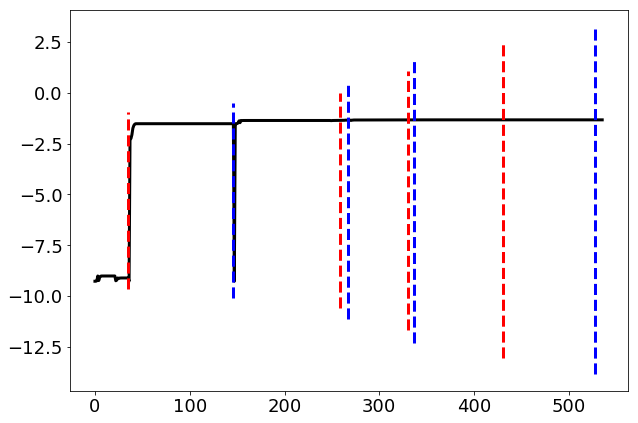

In [48]:
switch_poins_cum = [sum(switch_points[:i+1]) for i in range(len(switch_points))]
fig, axs = plt.subplots(1,1, figsize=(10,7))

t = np.arange(len(J1s))
axs.plot(t, J1s, c='k')
for i in range(len(switch_points)):
    if i % 2 == 0:
        axs.plot(switch_poins_cum[i]*np.array([1,1]), plt.get(axs, 'ylim'), 'r--')
    else:
        axs.plot(switch_poins_cum[i]*np.array([1,1]), plt.get(axs, 'ylim'), 'b--')

In [49]:
thetas_after_var_em_step, w_after_var_em_step

(array([ 0.5       ,  3.28907057,  3.89711094,  3.90926184,  3.90926184]),
 [array([1, 1, 1]),
  array([ 1.,  1.,  1.]),
  array([-2.25367516,  1.20711199,  0.94258596]),
  array([-2.71062923,  0.76501991,  1.51357594]),
  array([-3.43919429,  0.47337132,  1.34329873])])

In [50]:
lower_bounds = [np.zeros(n_theta) for i in range(int(num_em_steps/2)+1)]
for i in range(int(num_em_steps/2)+1):
    w = w_after_var_em_step[i]
    for j in range(n_theta):
        # compute lower bound
        lower_bounds[i][j] = compute_J1_analytic(x, y, thetas[j], w)

### coordinate ascent visualisation

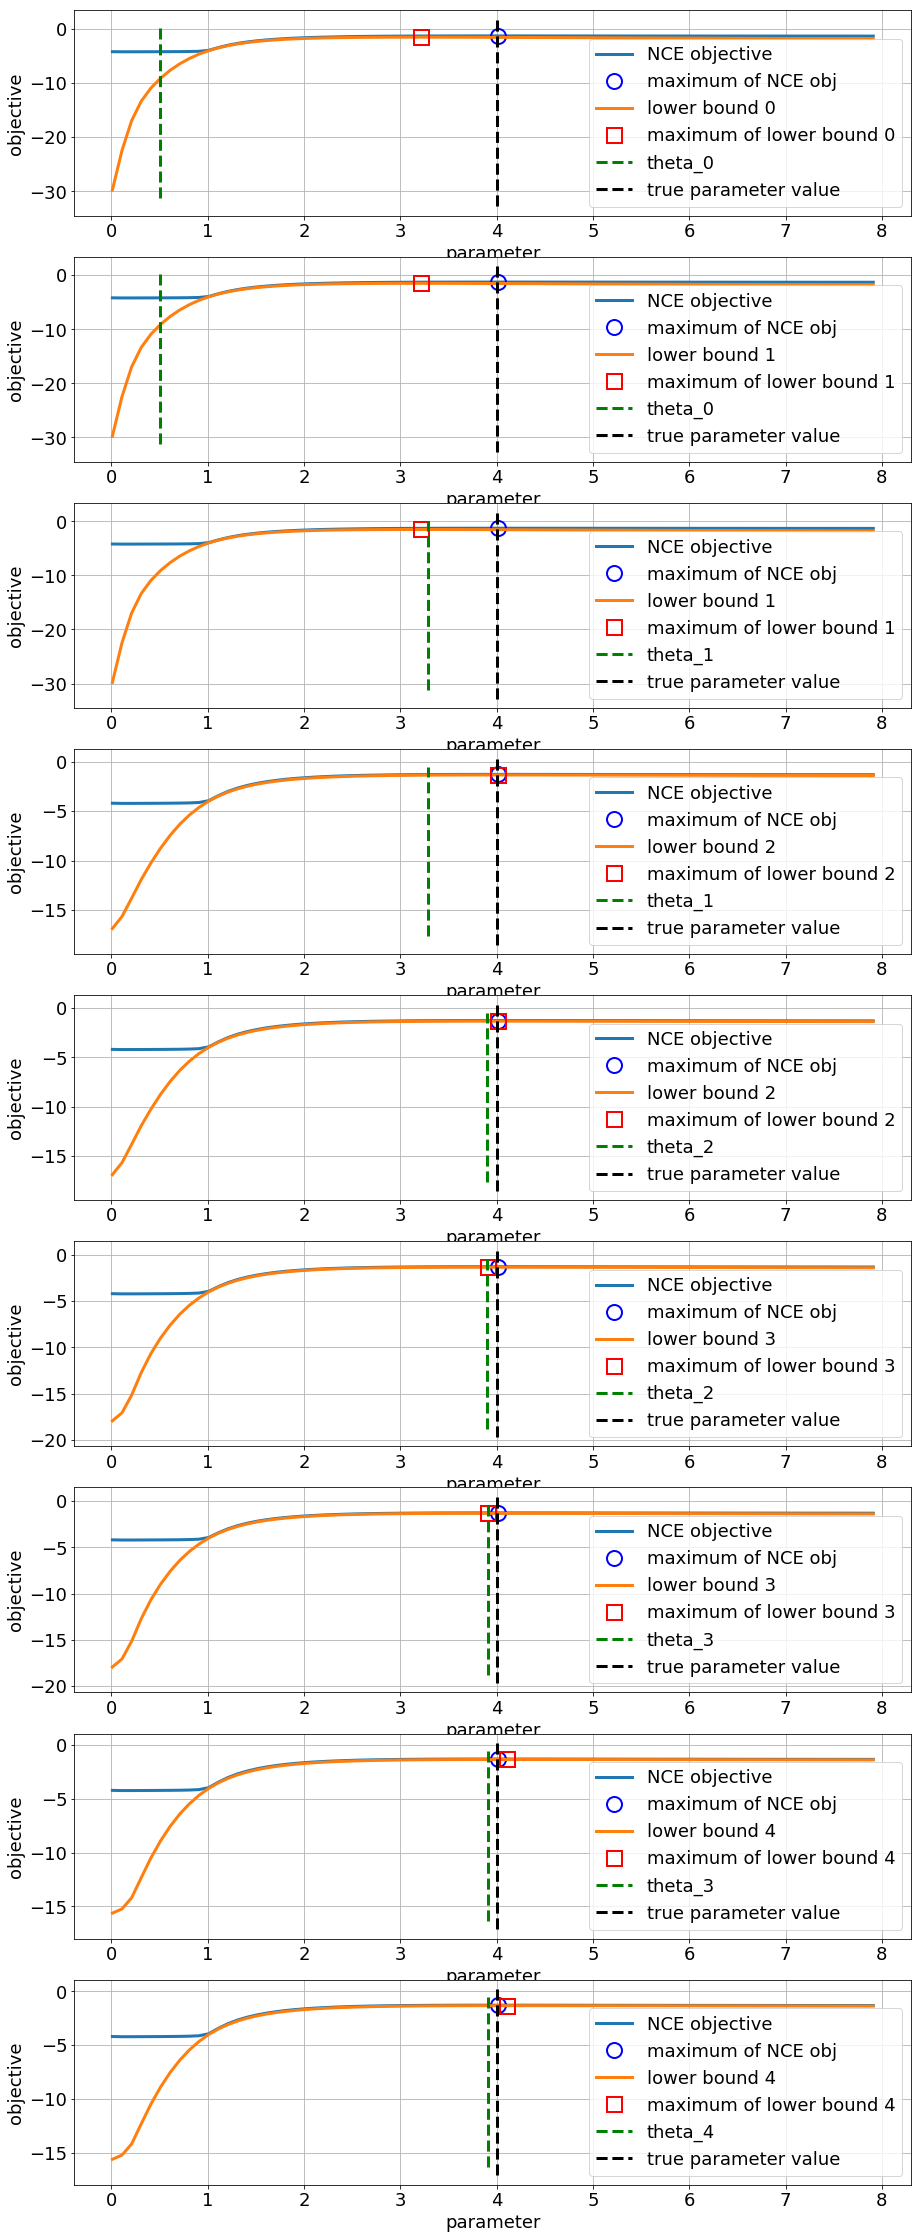

In [51]:
fig, axs = plt.subplots(num_em_steps+1, 1, figsize=(15, 40))
axs = axs.ravel()

for i in range(num_em_steps + 1):
    # plot NCE objective and its maximum
    axs[i].plot(thetas, J, label='NCE objective')
    J_index = np.argmax(J)
    axs[i].plot(thetas[J_index],J[J_index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='b', linestyle='none', label='maximum of NCE obj')
    
    lb = lower_bounds[int(np.ceil(i/2))]
    axs[i].plot(thetas, lb, label='lower bound {}'.format(int(np.ceil(i/2))))
   
    lb_index = np.argmax(lb)
    # maximiser of lower bound
    axs[i].plot(thetas[lb_index], lb[lb_index], 'rs', markersize=15, fillstyle='none', 
             markeredgewidth=2, linestyle='none', label='maximum of lower bound {}'.format(int(np.ceil(i/2))))
    
    # current theta value
    axs[i].plot(thetas_after_var_em_step[int(i/2)] * np.array([1,1]),
                plt.get(axs[i],'ylim'), 'g--', label='theta_{}'.format(int(i/2)))
    # true param value
    axs[i].plot(sigma0 * np.array([1,1]), plt.get(axs[i],'ylim'), 'k--', label='true parameter value')

    axs[i].set_xlabel('parameter')
    axs[i].set_ylabel('objective')
    axs[i].legend(loc='lower right', numpoints=1)
    axs[i].grid()